# Brain Tumor Classifier
## (Using MRI Imaging)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### Setting up paths/directories

In [2]:
import os

data_path = "/content/drive/MyDrive/brain_mri"

# Define subfolder names
sub_names = ['glioma', 'notumor', 'meningioma', 'pituitary']

# Process files within each subfolder of "training"
train_dir = os.path.join(data_path, 'Training')

# Process files within each subfolder of "testing"
test_dir = os.path.join(data_path, 'Testing')


Now we can write a loop that helps create a new dataframe with training data and subsequent folder names/category of tumor

In [3]:
import pandas as pd

train_data = []
for sub in sub_names:
  folder_path = os.path.join(train_dir, sub)
  images = os.listdir(folder_path)
  count = len(images)
  train_data.append(pd.DataFrame({"Image": images, "Tumor Type": [sub] * count, "Count": [count] * count}))

train_df = pd.concat(train_data)
print(train_df.head())

            Image Tumor Type  Count
0  Tr-gl_0668.jpg     glioma   1361
1  Tr-gl_0615.jpg     glioma   1361
2  Tr-gl_0203.jpg     glioma   1361
3  Tr-gl_0619.jpg     glioma   1361
4  Tr-gl_0556.jpg     glioma   1361


In [4]:
train_grouped = train_df.groupby("Tumor Type").count()

print(train_grouped)

            Image  Count
Tumor Type              
glioma       1361   1361
meningioma   1381   1381
notumor      1675   1675
pituitary    1547   1547


In [5]:
import plotly.graph_objects as go
import plotly.express as px


train_grouped = train_df.groupby("Tumor Type").count()

colors = ['#ff6666', '#ffff99', '#6666ff', '#99ff99']


fig = go.Figure(data=[go.Bar(x=train_grouped.index, y=train_grouped["Count"], marker=dict(color=colors))])
fig.update_layout(title="Count of Tumor Types (Training Data)", xaxis_title="Tumor Type", yaxis_title="Count", width = 600, height = 400)

fig.show()


Now we can display the first 10 images of the testing glioma variable to ensure we have loaded in the images properly.

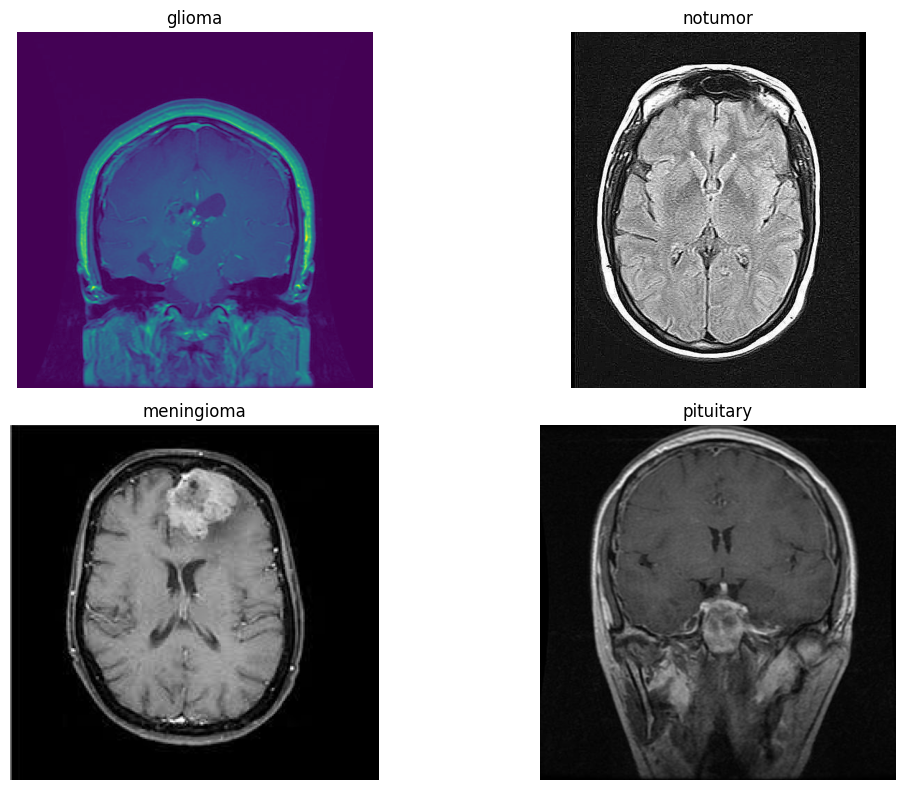

In [6]:
import matplotlib.pyplot as plt

# generate samples for each tumor type
plt.figure(figsize=(12, 8))
for i, sub in enumerate(sub_names):
    folder_path = os.path.join(train_dir, sub)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(sub)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Preprocessing the images prior to training

In [7]:
img_size = (128, 128)

batch_size = 25

epochs = 10

The following code will rescale the images to the same size, will zoom into each image by 12%, and will flip each image. This will allow for proper image augmentation and will strengthen the model

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_images_train = ImageDataGenerator(rescale = 1./255, rotation_range = 20, horizontal_flip = True, zoom_range = 0.12)

train_gen = gen_images_train.flow_from_directory(train_dir, target_size = img_size, batch_size = batch_size, class_mode = "categorical")

gen_images_test = ImageDataGenerator(rescale = 1./255)

test_gen = gen_images_test.flow_from_directory(test_dir, target_size = img_size, batch_size = batch_size, class_mode = "categorical", shuffle = False)


Found 5964 images belonging to 4 classes.
Found 1381 images belonging to 4 classes.


### Training the Convolutional Neural Network algorithm (CNN)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

algo = Sequential()
algo.add(Conv2D(32, (3,3), activation = "relu", padding = "same", input_shape = (128, 128, 3)))
algo.add(MaxPooling2D(pool_size = (2, 2)))
algo.add(Conv2D(64, (3,3), activation = "relu"))
algo.add(MaxPooling2D(pool_size = (2, 2)))
algo.add(Conv2D(128, (3,3), activation = "relu"))
algo.add(MaxPooling2D(pool_size = (2, 2)))
algo.add(Conv2D(64, (3,3), activation = "relu"))
algo.add(MaxPooling2D(pool_size = (2, 2)))
algo.add(Conv2D(64, (3,3), activation = "relu"))
algo.add(MaxPooling2D(pool_size = (2, 2)))
algo.add(Flatten())
algo.add(Dense(256, activation = "relu"))
algo.add(Dense(len(sub_names), activation = "softmax"))

In [10]:
algo.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

CNN_model = algo.fit(train_gen, epochs = epochs, steps_per_epoch = train_gen.samples // batch_size, validation_data = test_gen, validation_steps = test_gen.samples // batch_size)

Epoch 1/20
238/238 [==============================] - 1287s 5s/step - loss: 0.8758 - accuracy: 0.6238 - val_loss: 0.7017 - val_accuracy: 0.7091
Epoch 2/20
238/238 [==============================] - 48s 202ms/step - loss: 0.5506 - accuracy: 0.7860 - val_loss: 0.5757 - val_accuracy: 0.7731
Epoch 3/20
238/238 [==============================] - 48s 201ms/step - loss: 0.4322 - accuracy: 0.8321 - val_loss: 0.5290 - val_accuracy: 0.7876
Epoch 4/20
238/238 [==============================] - 51s 212ms/step - loss: 0.3634 - accuracy: 0.8631 - val_loss: 0.4547 - val_accuracy: 0.8305
Epoch 5/20
238/238 [==============================] - 50s 211ms/step - loss: 0.3068 - accuracy: 0.8838 - val_loss: 0.4242 - val_accuracy: 0.8480
Epoch 6/20
238/238 [==============================] - 51s 214ms/step - loss: 0.2528 - accuracy: 0.9074 - val_loss: 0.4809 - val_accuracy: 0.8422
Epoch 7/20
238/238 [==============================] - 51s 213ms/step - loss: 0.2345 - accuracy: 0.9129 - val_loss: 0.2899 - val_acc

### Evaluating the accuracy, and other model metrics

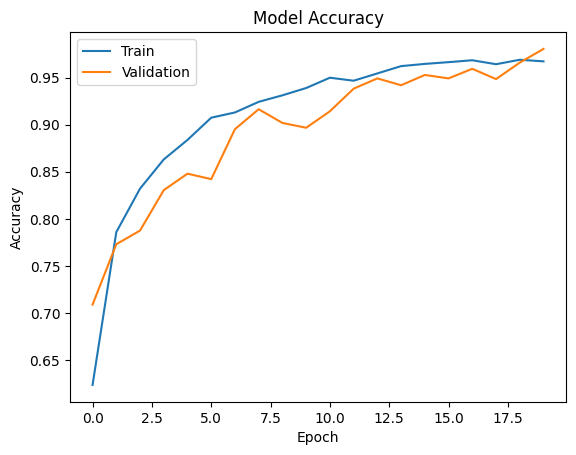

In [18]:
plt.plot(CNN_model.history['accuracy'])
plt.plot(CNN_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

With an accuracy of 97% and a validation accuracy of 98%, we can confidently use 20 epochs to train the model

In [19]:
loss, accuracy = algo.evaluate(test_gen, steps=test_gen.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

55/55 [==============================] - 5s 83ms/step - loss: 0.0662 - accuracy: 0.9804
Test Loss: 0.066188283264637
Test Accuracy: 0.9803636074066162


This is a very strong model! with a loss of only 0.066 and an accuracy of over 98%!